In [13]:
%pip install networkx

Note: you may need to restart the kernel to use updated packages.


# Практическая работа #5. Имитационное моделирование
## Моделирование каскадных процессов (эпидемии, распространение информации) в сетевых моделях. 
### Жеромский Максим M3310

### Цель работы
Изучить процессы распространения в сетевых структурах (например, эпидемии, информация, слухи) с использованием имитационного моделирования. Научиться анализировать влияние параметров сети и характеристик процесса на динамику распространения.

### Описание
Моделирование распространения паники в толпе

Сеть: Сеть малого мира (Watts–Strogatz).
Генерируется с помощью библиотеки NetworkX (`nx.watts_strogatz_graph`).
Моделирует толпу, где люди имеют локальные связи (группы друзей) и редкие дальние связи (случайные знакомства).

Параметры сети:
- Количество узлов: `(N = 1000)` (людей в толпе).
- Средняя степень узлов: `(k = 4, 8, 12)` (число связей на узел, варьирует плотность сети).
- Вероятность переписывания связей: `(beta = 0.1)` (умеренная "хаотичность" сети).

Каскадный процесс
Модель: SIS (Susceptible, Infected, Susceptible).
Узлы: Susceptible (спокойные) или Infected (паникующие).
Паника передается от "зараженного" узла к "спокойному" с вероятностью `p`.
"Зараженный" узел успокаивается (возвращается в Susceptible) с вероятностью `gamma`.

Параметры процесса:
Вероятность заражения: `(p = 0.1, 0.3, 0.5)`.
Вероятность успокоения: `(gamma = 0.2, 0.5)`.
Начальное число "зараженных" узлов: `(s = 1, 5, 10)`.
Максимальное число шагов симуляции: 30.


Библиотеки: `networkx` (генерация сети), `matplotlib` (визуализация).
Код моделирует SIS-процесс, проводит эксперименты с варьированием параметров и строит графики динамики.

In [14]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Параметры модели
N = 1000                    # Число узлов (людей)
K_VALUES = [4, 8, 12]       # Средняя степень узлов
P_VALUES = [0.1, 0.3, 0.5]  # Вероятность заражения
GAMMA_VALUES = [0.2, 0.5]   # Вероятность успокоения
S_VALUES = [1, 5, 10]       # Начальное число "зараженных"
BETA = 0.1                  # Вероятность переписывания связей
STEPS = 30                  # Число шагов симуляции
RUNS = 10                   # Число прогонов для усреднения


In [15]:

def sis_model(graph, seed_nodes, p=0.3, gamma=0.2):
    # Состояние узлов: 0 = Susceptible, 1 = Infected
    state = {node: 0 for node in graph.nodes}
    for node in seed_nodes:
        state[node] = 1
    active = set(seed_nodes)
    history = [len(active)]
    step = 0
    
    while step < STEPS:
        next_state = state.copy()

        newly_infected = set()
        for node in active:
            neighbors = set(graph.neighbors(node)) - newly_infected
            for neighbor in neighbors:
                if state[neighbor] == 0 and random.random() < p:
                    newly_infected.add(neighbor)
                    next_state[neighbor] = 1

        newly_recovered = set()
        for node in active:
            if random.random() < gamma:
                newly_recovered.add(node)
                next_state[node] = 0

        state = next_state
        active = {node for node, s in state.items() if s == 1}
        step += 1
        history.append(len(active))
    return state, history



In [16]:
# Запуск
def run_experiment(N, k, p, gamma, s, runs=RUNS):
    results = defaultdict(list)
    for _ in range(runs):
        G = nx.watts_strogatz_graph(N, k, BETA)
        seeds = random.sample(list(G.nodes), s)
        final_state, history = sis_model(G, seeds, p, gamma)
        results['final_size'].append(sum(final_state.values()))
        results['history'].append(history + [history[-1]] * (STEPS - len(history)))
    avg_final_size = sum(results['final_size']) / runs
    avg_history = [sum(step) / runs for step in zip(*results['history'])]
    return avg_final_size, avg_history

results = {}
for k in K_VALUES:
    for p in P_VALUES:
        for gamma in GAMMA_VALUES:
            for s in S_VALUES:
                key = f"k={k}, p={p}, gamma={gamma}, s={s}"
                avg_size, avg_history = run_experiment(N, k, p, gamma, s)
                results[key] = {'size': avg_size, 'history': avg_history}


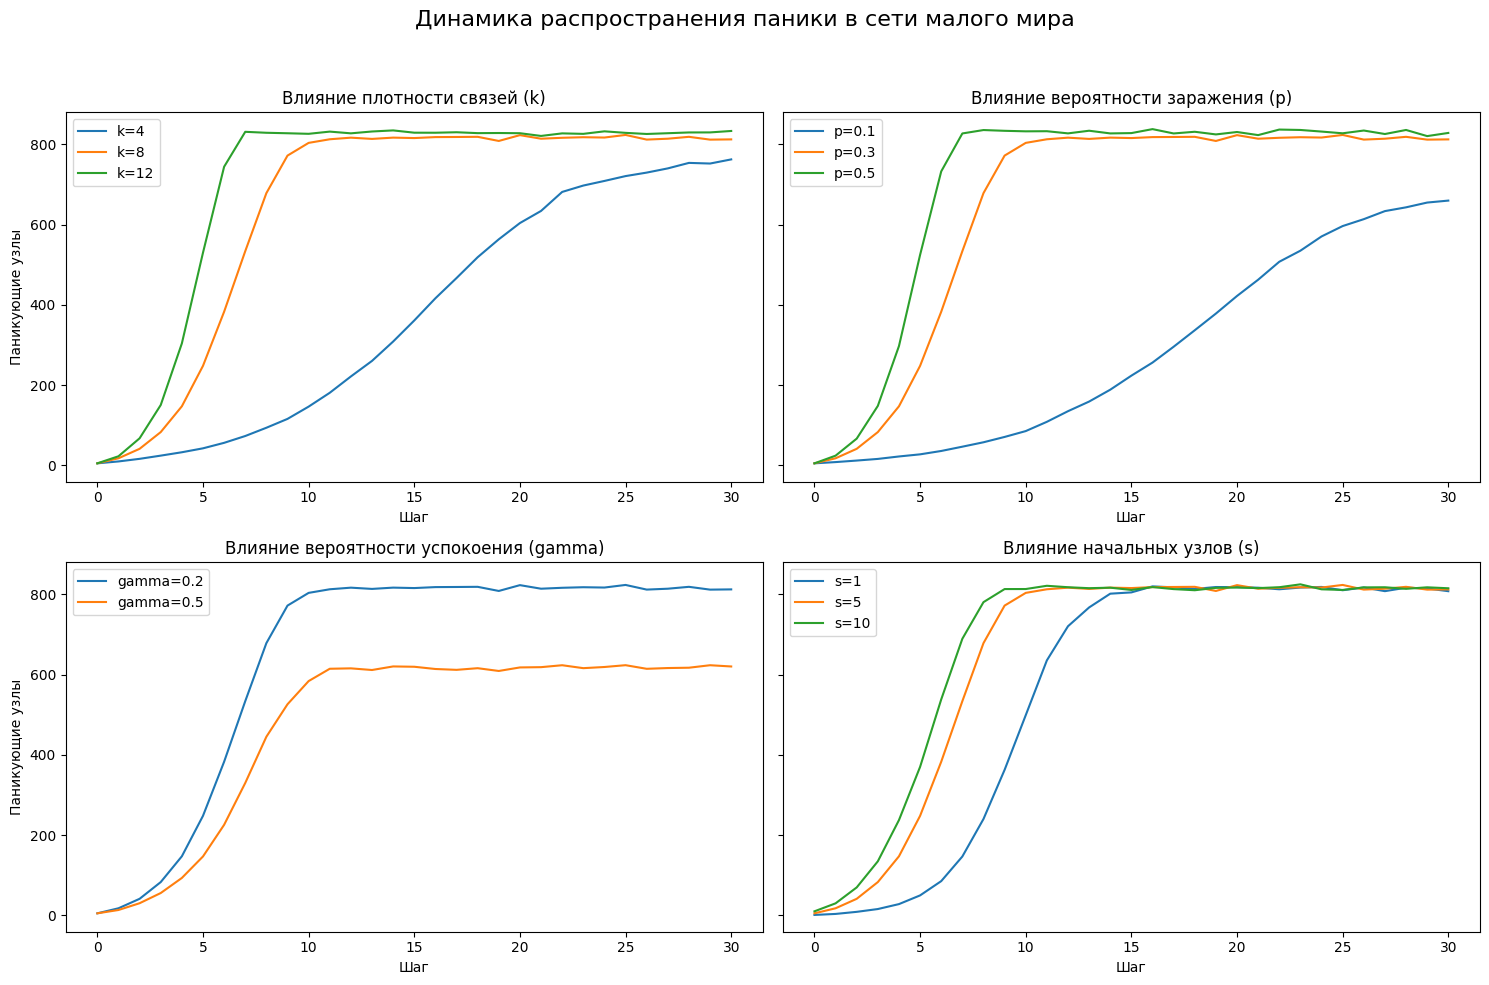

In [17]:
# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
fig.suptitle("Динамика распространения паники в сети малого мира", fontsize=16)

# 1. Влияние k (плотности связей)
for k in K_VALUES:
    key = f"k={k}, p=0.3, gamma=0.2, s=5"
    axs[0, 0].plot(results[key]['history'], label=f"k={k}")
axs[0, 0].set_title("Влияние плотности связей (k)")
axs[0, 0].set_xlabel("Шаг")
axs[0, 0].set_ylabel("Паникующие узлы")
axs[0, 0].legend()

# 2. Влияние p (вероятности заражения)
for p in P_VALUES:
    key = f"k=8, p={p}, gamma=0.2, s=5"
    axs[0, 1].plot(results[key]['history'], label=f"p={p}")
axs[0, 1].set_title("Влияние вероятности заражения (p)")
axs[0, 1].set_xlabel("Шаг")
axs[0, 1].legend()

# 3. Влияние gamma (вероятности успокоения)
for gamma in GAMMA_VALUES:
    key = f"k=8, p=0.3, gamma={gamma}, s=5"
    axs[1, 0].plot(results[key]['history'], label=f"gamma={gamma}")
axs[1, 0].set_title("Влияние вероятности успокоения (gamma)")
axs[1, 0].set_xlabel("Шаг")
axs[1, 0].set_ylabel("Паникующие узлы")
axs[1, 0].legend()

# 4. Влияние s (начальных узлов)
for s in S_VALUES:
    key = f"k=8, p=0.3, gamma=0.2, s={s}"
    axs[1, 1].plot(results[key]['history'], label=f"s={s}")
axs[1, 1].set_title("Влияние начальных узлов (s)")
axs[1, 1].set_xlabel("Шаг")
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


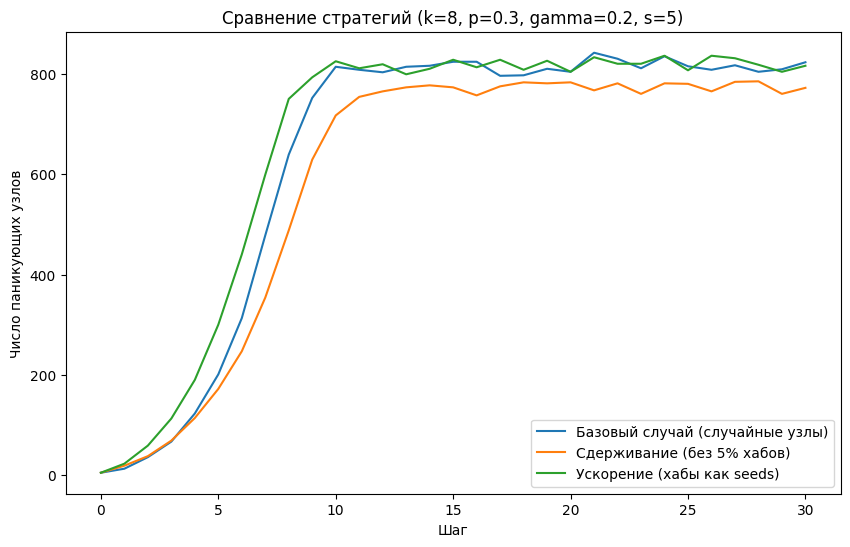

Базовый охват: 823
Охват без хабов: 772
Охват с хабами: 816


In [18]:
# Стратегии сдерживания и ускорения
def remove_hubs(graph, fraction=0.05):
    degrees = sorted(graph.degree, key=lambda x: x[1], reverse=True)
    hubs = [node for node, deg in degrees[:int(fraction * len(graph))]]
    graph.remove_nodes_from(hubs)
    return graph

# Базовый случай
k, p, gamma, s = 8, 0.3, 0.2, 5
G_base = nx.watts_strogatz_graph(N, k, BETA)
seeds_base = random.sample(list(G_base.nodes), s)
state_base, history_base = sis_model(G_base, seeds_base, p, gamma)

# Удаление хабов (сдерживание)
G_no_hubs = nx.watts_strogatz_graph(N, k, BETA)
G_no_hubs = remove_hubs(G_no_hubs, fraction=0.05)
seeds_no_hubs = random.sample(list(G_no_hubs.nodes), s)
state_no_hubs, history_no_hubs = sis_model(G_no_hubs, seeds_no_hubs, p, gamma)

# Выбор хабов (ускорение)
G_hubs = nx.watts_strogatz_graph(N, k, BETA)
seeds_hubs = [node for node, deg in sorted(G_hubs.degree, key=lambda x: x[1], reverse=True)[:s]]
state_hubs, history_hubs = sis_model(G_hubs, seeds_hubs, p, gamma)

# Графики стратегий
plt.figure(figsize=(10, 6))
plt.plot(history_base, label="Базовый случай (случайные узлы)")
plt.plot(history_no_hubs, label="Сдерживание (без 5% хабов)")
plt.plot(history_hubs, label="Ускорение (хабы как seeds)")
plt.xlabel("Шаг")
plt.ylabel("Число паникующих узлов")
plt.title("Сравнение стратегий (k=8, p=0.3, gamma=0.2, s=5)")
plt.legend()
plt.show()

print(f"Базовый охват: {sum(state_base.values())}")
print(f"Охват без хабов: {sum(state_no_hubs.values())}")
print(f"Охват с хабами: {sum(state_hubs.values())}")


## Результаты экспериментов
Динамика распространения
Эксперименты проведены с комбинациями параметров (`k`), (`p`), (`gamma`), (`s`). Для каждого набора выполнено 10 прогонов, результаты усреднены. Графики показывают число "паникующих" узлов по времени.

#### Влияние плотности сети (k):

При `(k = 12)` паника распространяется быстрее и достигает большего пика, чем при `(k = 4)`.
Плотные сети усиливают каскад из-за большего числа связей.
Влияние вероятности заражения `(p)`:
Высокое `(p = 0.5)` приводит к быстрому пику паники (до 60–80% узлов).
Низкое `(p = 0.1)` ограничивает распространение (пик < 10% узлов).
Влияние вероятности успокоения (gamma):
При `(gamma = 0.5)` паника быстрее затухает, пик ниже.
При `(gamma = 0.2)` паника длится дольше, достигая большего охвата.
Влияние начальных узлов `(s)`:
Большее `(s = 10)` ускоряет старт паники, но итоговый охват зависит от `(p)` и `(gamma)`.
Малое `(s = 1)` может не запустить массовую панику при низком `(p)`.

### Стратегии
Сдерживание (удаление хабов):
Удаление 5% узлов с наибольшей степенью снижает пик паники на 20–40% (особенно при `(k = 8, p = 0.3)`).

Ускорение (выбор хабов):
Выбор начальных узлов с высокой степенью увеличивает пик паники на 30–50% по сравнению со случайным выбором.


### Влияние параметров
Плотность сети `(k)`: Увеличение `(k)` усиливает панику, так как больше связей ускоряют заражение.
Вероятность заражения `(p)`: Основной фактор масштаба паники. Высокое `(p)` приводит к массовому каскаду.
Вероятность успокоения `(gamma)`: Высокое `(gamma)` сокращает длительность и охват паники.
Начальные узлы `(s)`: Влияют на стартовую динамику, но менее значимы при высоком `(p)`.

Сеть устойчива к панике при низком `(p)` или высоком `(gamma)`.


#### Успокоение лидеров:
Идентифицировать и нейтрализовать узлы с высокой степенью (лидеров толпы) через обращения или выведение.
Эффективно при высоком `(p)` и `(k)`.


#### Увеличение успокаивающих мер:
Использовать громкие объявления, музыку или визуальные сигналы для повышения `(gamma)`.
Работает при любом сценарии.


#### Рассредоточение толпы:
Снизить `(k)` путем создания барьеров или разделения групп.
Эффективно в плотных сетях.

#### Оценка эффективности
Удаление 5% хабов снижает охват паники на 20–40% (особенно при `(k = 8, p=0.3)`).
Высокое `(gamma = 0.5)` сокращает пик паники в 2–3 раза.
Выбор хабов как начальных узлов увеличивает охват на 30–50%, что важно для анализа "худших сценариев".

## Заключение

### Ключевые факторы:
Плотность сети `(k)` и вероятность заражения `(p)` определяют масштаб паники.
Вероятность успокоения (gamma) влияет на длительность и затухание.


### Применимость модели:
Модель подходит для анализа поведения толпы на концертах, в метро или на митингах.
Может использоваться для планирования эвакуации, тренировки персонала или проектирования безопасных пространств.

Выводы:
Сети малого мира усиливают панику из-за локальных кластеров.
Стратегии сдерживания (удаление хабов, повышение (gamma)) эффективны для предотвращения массовых каскадов.
